# Smart image cropping with Seam Carving

**by Filipe Chagas Ferraz**

![](plots/seam-carving-filipe.gif)

Seam Carving is an image processing algorithm that resizes images by removing or inserting paths of pixels ("seams") with the least visual importance, preserving key content while reducing size. Ideal for smart cropping and aspect ratio adjustments.

The key elements of Seam Carving are:
* A filter that replaces pixel values with energy values
* A heuristic to find the minimum-energy vertical or horizontal path in the image

These elements are described in the two sections bellow.

### Energy filter
Let $X \in \mathbb{R}^{H\times W}$ be a grayscale image with height $H$ and width $W$. A filter, in this case, is a function $X' = F(X)$ where $X'$ is the output image. The filter can be a pixel-wise function, i.e., $X'_{i,j} = f(X_{i,j})$, where $X_{i,j}$ is the pixel in the i-th row and j-th column of $X$, or a region-dependent function, i.e., $X'_{i,j} = f(X_{i-N,j-N}, \dots, X_{i,j}, \dots, X_{i+N,j+N})$, which computes $X'_{i,j}$ based on the values of a group of pixels surrounding $X_{i,j}$.

An energy filter $X' = E(X)$ assigns values to $X'_{i,j}$ that indicate the how important is the content surrounding $X_{i,j}$. That "importance index" can be defined in various ways, such as gradient magnitude or local entropy. In this tutorial, the gradient magnitude is used as energy filter.

The gradient magnitude filter is defined as $X'_{i,j} = \sqrt{A_{i,j} + B_{i,j}}$ where $A$ and $B$ are outputs of horizontal and vertical sobel filters, i.e.:

$$A = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} \circledast X$$

$$B = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix} \circledast X$$

### Minimum-energy path finding

An energy path is a vertical or horizontal sequence of neighboring pixels $P=[X'_{i_1,j_1}, X'_{i_2,j_2}, X'_{i_3,j_3}, ...]$. 

* If the path is **vertical**, it starts with a pixel of the first row and ends with a pixel of the last row, i.e., $P=[X'_{1,j_1}, ..., X'_{H,j_H}]$. As the pixels are neighbors, its indexes $(i,j)$ should follow the rules $i_k = i_{k-1}+1$ and $j_k = j_{k-1} + \Delta_k$ where $\Delta_k \in \{-1, 0, 1\}$.
* If the path is **horizontal**, it starts with a pixel of the first column and ends with a pixel of the last column, i.e., $P=[X'_{i_1,1}, ..., X'_{i_W,W}]$. The pixel indexes $(i,j)$ should follow the rules $j_k = j_{k-1}+1$ and $i_k = i_{k-1} + \Delta_k$ where $\Delta_k \in \{-1, 0, 1\}$.

When Seam Carving reduces an image's width or height by one pixel, it finds a vertical or horizontal path where the total energy $\sum_k P_k$ is minimal (the minimum-energy path) and removes it. The direction (vertical or horizontal) of this path is perpendicular to the one which the image is being compressed. Finding this path requires a fast heuristic algorithm, and in this tutorial, a greedy path-finding algorithm is used.

## Implementation

We will use the scikit-image package to do the basics of image processing.

In [1]:
# Scikit-image installation
!pip install scikit-image


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np # Numerical processing
import matplotlib.pyplot as plt # Plotting
from skimage.io import imread # Function to load an image file
from skimage.filters import sobel_h, sobel_v # Functions to compute sobels filters
from skimage.transform import resize # Function to resize the image by linear iterpolation

In the next cell, we will load an image file to process using Seam Carving. Since the original image is large and we don’t want to spend too much time processing it, it will be rescaled to a height of 100px using linear interpolation.

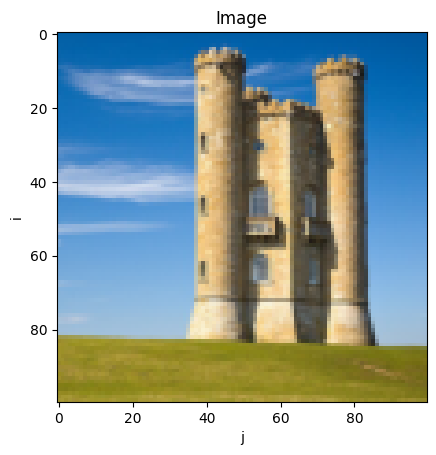

In [3]:
my_img = imread('input/640px-Broadway_tower_edit.jpg') # https://commons.wikimedia.org/wiki/File:Broadway_tower_edit.jpg#/media/File:Broadway_tower_edit.jpg
my_height = 100
my_img = resize(my_img, (my_height, my_img.shape[1]*my_height/my_img.shape[0]))

plt.imshow(my_img)
plt.title('Image')
plt.ylabel('i')
plt.xlabel('j')
plt.show()

The next step is to define a function to compute the energy filter. First, let’s see how the gradient magnitude works.

In the next cell, the RGB input image is converted to a single-channel grayscale image. This transformation is done by averaging the three channels into a single channel.

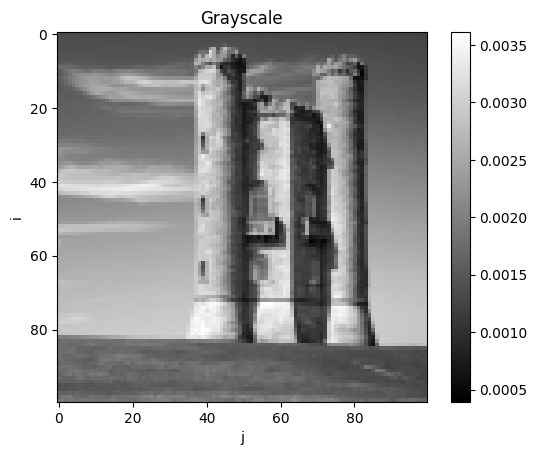

In [4]:
img_grayscale = lambda img : (img[:,:,0].astype(float) + img[:,:,1].astype(float) + img[:,:,2].astype(float))/3
img_gray = img_grayscale(my_img)
img_gray /= 255

plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

In the next two cells, the horizontal and vertical gradients ($A$ and $B$) of the image, computed using Sobel filters, are shown.

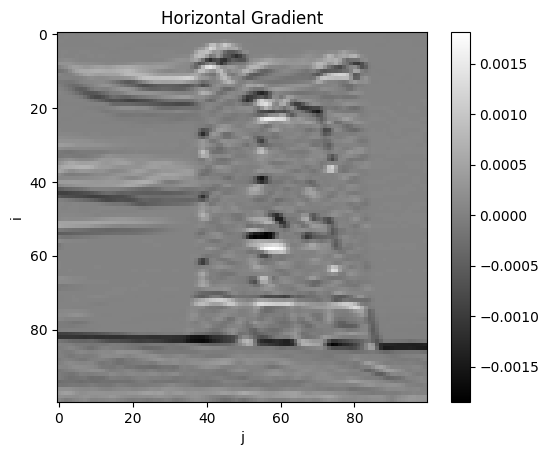

In [5]:
img_gray_grad_h = sobel_h(img_gray)

plt.imshow(img_gray_grad_h, cmap='gray')
plt.title('Horizontal Gradient')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

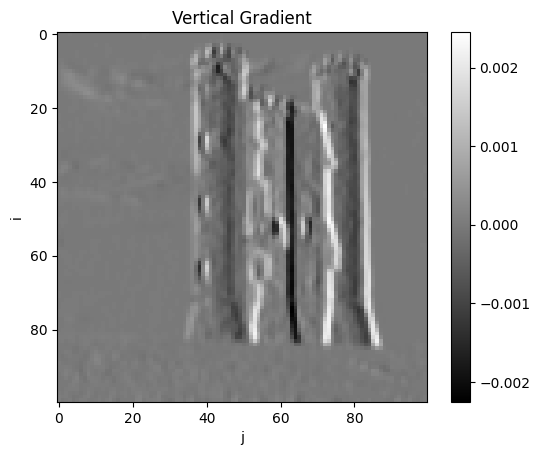

In [6]:
img_gray_grad_v = sobel_v(img_gray)

plt.imshow(img_gray_grad_v, cmap='gray')
plt.title('Vertical Gradient')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

In the next cell, the functions that compute the energy are defined. 

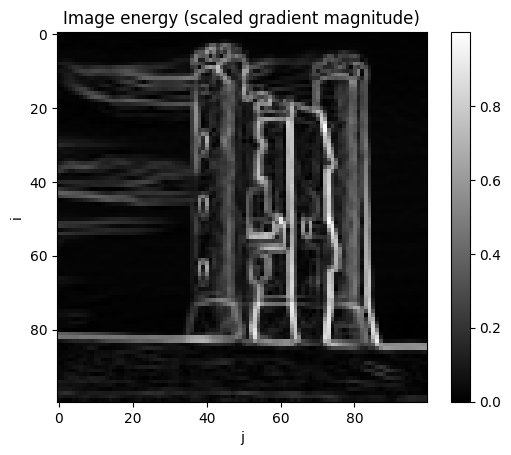

In [7]:
min_max_scaler = lambda arr: (arr - np.min(arr))/np.max(arr) #Function that rescales all values of an array to range from 0 to 1.

gradient_magnitude = lambda img: np.sqrt(sobel_h(img)**2 + sobel_v(img)**2) # Function that computes the gradient magnitude

energy_filter = lambda img: min_max_scaler(gradient_magnitude(img)) # Function that computes a gradient magnitude scaled from 0 to 1

img_energy = energy_filter(img_gray)
plt.imshow(img_energy, cmap='gray')
plt.title('Image energy (scaled gradient magnitude)')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

In the next cell, a function to find the minimum-energy vertical path is defined. This function uses a greedy heuristic to find a set of $W$ trial paths, each starting with a predefined $j$ coordinate from 0 to $W-1$. The trial path with least total energy is selected as the minimum-energy path. The greedy heuristic used to find a trial path is described bellow:

1. Let $j_\text{sequence} \in \mathbb{N}^H$ be the sequence of $j$ coordinates of the path and initialize it as  $j_\text{sequence} = [0,0,...,0]$. 
2. Let $i_\text{sequence} \in \mathbb{N}^H$ be the sequence of $i$ coordinates of the path and initialize it as $i_\text{sequence} = [0,1,2,...,H-1]$.
3. Let $j_0 \in \mathbb{N}$ be the initial $j$ coordinate and assign it to the first element of $j_\text{sequence}$, i.e., $j_\text{sequence}[0] \leftarrow j_0$.
4. For each $1 \leq i < H$ increasing 1 by 1, do:
    1. Evaluate each existing $X'_{i,j_\text{trial}}$, where $j_\text{trial} = j_\text{sequence}[i-1] + \Delta_\text{trial}$ and $\Delta_\text{trial} \in \{-1,0,1\}$.
    2. Select the $j_\text{trial}$ which $X'_{i,j_\text{trial}}$ is the least and assign it to $j_\text{sequence}[i]$, i.e., $j_\text{sequence}[i] \leftarrow \argmin_{j_\text{trial}}\{ X'_{i,j_\text{trial}} \}$
    
Note that, in the pseudocode above, sequence and image indices/coordinates start at 0, while in the theoretical sections of this tutorial, they start at 1.

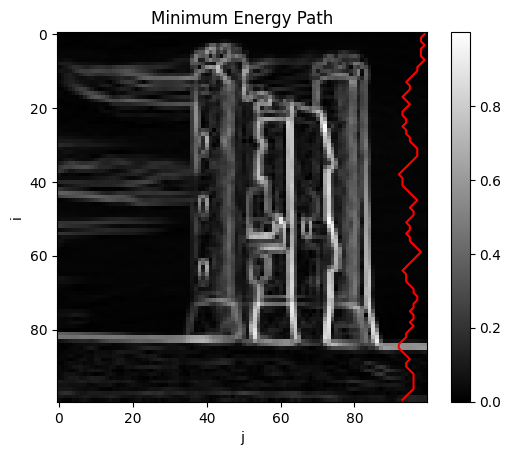

In [8]:
def greedy_vertical_path_finder(energy):
    height, width = energy.shape
    i_sequence = np.arange(height)
    
    def find_trial_path(initial_j):
        path_total_energy = energy[0, initial_j]
        j_sequence = np.zeros(shape=(height,), dtype=int)
        j_sequence[0] = initial_j
        for i in range(1, height):
            delta = min(
                    (-1, 0, 1), 
                    key = lambda _delta: energy[i, j_sequence[i-1]+_delta] if j_sequence[i-1]+_delta >= 0 and j_sequence[i-1]+_delta < width else float('inf')
                )
            j_sequence[i] = j_sequence[i-1] + delta
            path_total_energy += energy[i, j_sequence[i]]
        return j_sequence, path_total_energy

    selected_j_sequence, selected_total_energy = find_trial_path(0)
    for initial_j in range(1, width):
        current_j_sequence, current_total_energy = find_trial_path(initial_j)
        if current_total_energy < selected_total_energy:
            selected_total_energy = current_total_energy
            selected_j_sequence = current_j_sequence

    return list(zip(i_sequence, selected_j_sequence)), i_sequence, selected_j_sequence

# Function test
ij_seq, i_seq, j_seq = greedy_vertical_path_finder(img_energy)
plt.imshow(img_energy, cmap='gray')
plt.plot(j_seq, i_seq, color='red')
plt.title('Minimum Energy Path')
plt.ylabel('i')
plt.xlabel('j')
plt.colorbar()
plt.show()

In the next section, a function to remove a vertical path from a RGB image is defined.

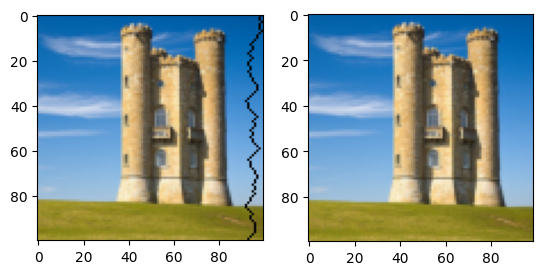

In [9]:
def remove_vertical_path(img, j_sequence):
    assert img.shape[0] == j_sequence.shape[0]
    height, width, n_channels = img.shape
    
    def process_channel(channel_img):
        rows = []
        for i in range(height):
            row_left_part = channel_img[i, :j_sequence[i]]
            row_right_part = channel_img[i, j_sequence[i]+1:]
            rows.append(np.append(row_left_part, row_right_part))
        return np.vstack(rows)

    output_img = np.zeros(shape=(height, width-1, n_channels))
    for channel in range(n_channels):
        output_img[:, :, channel] = process_channel(img[:, :, channel])

    return output_img

# Function test
my_img_ = my_img.copy()
for i, j in ij_seq:
    my_img_[i,j,:] = 0
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(my_img_)
ax[1].imshow(remove_vertical_path(my_img_, j_seq))
plt.show()

Finally, in the next section, the final function of horizontal Seam Carving is defined.

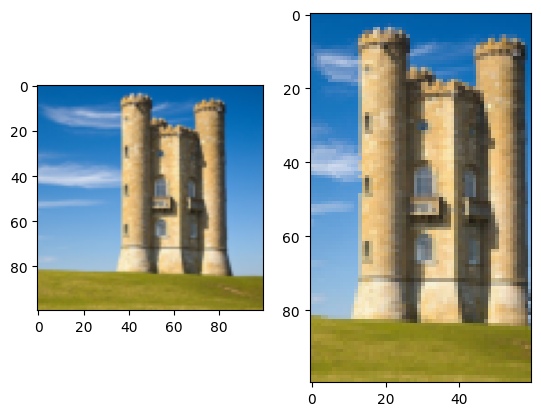

In [10]:
def horizontal_seam_carving(img, width_reduction):
    output_img = img.copy()
    for _ in range(width_reduction):
        energy = energy_filter(img_grayscale(output_img))
        ij_seq, i_seq, j_seq = greedy_vertical_path_finder(energy)
        output_img = remove_vertical_path(output_img, j_seq)
    return output_img

# Function test
resized_img = horizontal_seam_carving(my_img, 40)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(my_img)
ax[1].imshow(resized_img)
plt.show()